# First Parallel Scripts

Python Virtual Machine is a scalar program environment. He has only one execution thread.

If you need to execute a parallel algorithm, you need to use specific modules.
There are several modules (you can consult those modules in the follow link [https://wiki.python.org/moin/ParallelProcessing]).

The main problem is, most of the Parallel Modules, ar OS dependant.

One of the more compatible module is the multiprocessing module [https://docs.python.org/3.6/library/multiprocessing.html].




In [1]:
from multiprocessing import Pool
import multiprocessing as mp
import os
import numpy as np

To analyze our code we will import those two modules:
Time module, which allows us to make time calculae, like the time spend to execute our code.
cProfile, whic allows us profiling and analyze our code behaviour

In [2]:
import time
import cProfile 

# ^^^ tool to profile the code = we analyze how many times we invoke 
#and how much time it takes to execute and all the processor time
#To improve the execution of our code

## Detect the number of cores in your computer

We can get the number of CPU cores available in the computer using the methods multiprocessing.cpu_count() or os.cpu_count().

In [3]:
print (mp.cpu_count()) #mp is the alias for multiprocessing module 
print (os.cpu_count())


4
4


But, how many real cores contains our computer? 
* On linux:
On Linux, just look for "ht" on the "flags" line of /proc/cpuinfo. See for instance:
***
`grep '^flags\b' /proc/cpuinfo | tail -1`
***
or execute the command:
***
`lscpu` 
***
and check the field:
 
`Thread(s) per core:  2`

* On Windows:

On Windows, you can use the following command on PowerShell command line:
***
`WMIC CPU Get DeviceID,NumberOfCores,NumberOfLogicalProcessors`
***

Other option is opening the Task Manager, go to the **Performance** tab and select **CPU** from the left column. You’ll see the number of physical cores and logical processors on the bottom-right side.

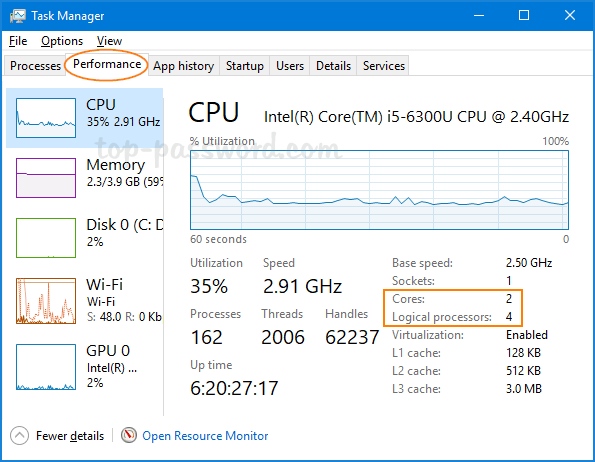


## PERSONAL LIBRARY
In the following cell we import the module where we will define the functions which we will execute in the parallel threads.

In [4]:
import myfunctions as my 

Everytime you make changes in the python file *myfunctions.py*, you have to reload them, to update the changes.

In [5]:
import importlib
importlib.reload(my) #RELOAD EVERY TIME SOMETHING CHANGES IN MYFUNCTIONS.PY

<module 'myfunctions' from '/Users/martaalmagro/Desktop/Massive computing/Session3_2022/myfunctions.py'>

## INSTRUCTIONS
Before start to write code, we need to analyze our task and design several items:
* Select the block which we will distribute
* How we will split the work
* Design the distributed function
* Decide how we will distribute the source data
* Design how we will collect the results
* Design how we will coordinate/sinchronize the parallel tasks

### First simple code: 
#### Our Task:
Implements a function which calculate the square value of a large number of elements in a vector and sum them.

#### Steps
1) Which parts we will distribute:
* We will not distribute the variables initialization
* Maybe intialize where the results will be stored (we will check and compare the time consuming)

2) How we will distribute the work
* In this case, we will use the multiprocess Pool object (https://docs.python.org/3.9/library/multiprocessing.html#multiprocessing.pool.Pool)
* Requisites/Parameters: 
    * processes: Number of process we will run in parallel simultaneously (if it is not provided, it will use the number returned by os.cpu_count())
    * Initializer: the function which will be invoked if it will be executed in a separated execution environment (a separated environment). Not used today.
    * Initializer parameters: array of elements who will be pass to the initializer function
    * maxtasksperchild: Maximum number of tasks processed by each child process. Once the workers reach this number, will be destroyed and initialize a new one.
We need to controls the number of process, because the os.cpu_count() will returns the number of execution threads, instead the number of real cores.

3) Design the distributed function:
    Our atomic element is each one value in the long vector.

    We will distribute this *atomic* element to our distributed function.
    
    In our first distributed example (section 1a) our atomic elemnt is a vector of size NUMELEMTS (10000000) divided by 64, which will be the total number of parallel proceseses we will run.
    
    For this case, the invoked function in parallel will be:
    <pre>
    def square_vector(idx):
        start_time = time.time()
        result = []
    
        data = np.random.rand(156250)
        for d in data:
            result.append(f(d))
        total_time=time.time()-start_time
        print("Hi, i am the task index {0}, time {1}".format(idx,total_time))
        return total_time    
    </pre>
    
    The second example, the distributed function will takes a single element, and returns the square value of the element.
    <pre>
    def f(x):
      return x*x
    </pre>
    If we are running in a Windows OS, this function must be defined in a separated module (in our case, myfunctions.py module) and import in the main script.

    If we are running in a Linux/MacOS/\*NIX environment, can be defined in the main script. 

4) How we will distribute the source data:
    In this first example, we will pass use the **Pool.map** function to pass to the distributed function each one of the values in the data source vector. The problem is, the parameter passed to the **Pool.map** function must be an iterable variable, to fetch the parameters to pass to the function.
    
    In our case, we can use the original data vector as iterable parameter for the **Pool.map** function.
    
    For advanced functions, we can use global variables (always just to read values) or pass the original values to each one of the executor threads, in the initialization function in the **Pool** object.
   
5) How we will collect the results:
    The **Pool.map** returns ordered the returned value from the invoked function. 

    For advanced functions, we can use shared memory, taking care about the hazzards, and using semaphores or memory locks.
   
6) Design how we will coordinate/sinchronize the parallel tasks
    The **Pool.map** function synchronize the execution tasks, returning the results in ordered way. 
    
    If we use **Pool.map_async** function, we needs ti fetch the results data with the **VARIABLE.get(*timeout*)** method, where **VARIABLE** is the assigned variable to **Pool.map_Async** object.

Execute a program who allows to check the CPU consume:
* Linux: Open a terminal and execute **top** comand
* MacOS: Execute **Activity Monitor** and open **CPU Usage** window
* Windows: Open the Task Manager, go to the Performance tab and select CPU from the left column, then select **Open Resource Manager** in the bottom of the window.

Please, check the conditions in your computer and replace the \<FILL IN\> sentence with the correct command or value.

In [6]:
IS_HT=True #True if your computer have the HyperThreading feature activated, False if not.
NUMREPORTEDCORES=mp.cpu_count() 
#Should be the number of real computational cores
if IS_HT:
    NUMCORES=(int) (NUMREPORTEDCORES/2)
else:
    NUMCORES=NUMREPORTEDCORES
    
print("Number of processes: {0}".format(NUMCORES))

Number of processes: 2


In [7]:
%%time
#We will generate the test data
NUMDATA=10000000

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


#### 1a) First Parallel Task
We will generate 64 separate random vectors of size 156250 and calculate the square value of each element in the vector. The distributed function will identify the task index and prints the individual time and the full taken time (we returns te taked time to execute code).

In [8]:
NUM_PARALLELPROCS=128 
NUM_ELEMENTSVECTOR=NUMDATA/NUM_PARALLELPROCS
print("The number of elements in the generated vector in the function my.square_vector is: {0}".format(NUM_ELEMENTSVECTOR))

The number of elements in the generated vector in the function my.square_vector is: 78125.0


In [9]:
idx = range(NUM_PARALLELPROCS)

In [10]:
%%time
start_time = time.time()
with Pool(NUMCORES) as p:
    result_t=p.map(my.square_vector,idx)
time_block = time.time() - start_time
print("Total optimized time {0} secs" .format(time_block)) 

Hi, i am the task index 0, time 0.030106067657470703
Hi, i am the task index 1, time 0.0375361442565918
Hi, i am the task index 2, time 0.029801130294799805
Hi, i am the task index 3, time 0.026633024215698242
Hi, i am the task index 4, time 0.028178930282592773
Hi, i am the task index 5, time 0.02651381492614746
Hi, i am the task index 6, time 0.026755094528198242
Hi, i am the task index 7, time 0.026714086532592773
Hi, i am the task index 8, time 0.0279386043548584
Hi, i am the task index 9, time 0.028411865234375
Hi, i am the task index 10, time 0.02550816535949707
Hi, i am the task index 11, time 0.026561975479125977
Hi, i am the task index 12, time 0.026222705841064453
Hi, i am the task index 13, time 0.02593517303466797
Hi, i am the task index 14, time 0.026835918426513672
Hi, i am the task index 15, time 0.025287866592407227
Hi, i am the task index 32, time 0.028813838958740234
Hi, i am the task index 33, time 0.028182029724121094
Hi, i am the task index 34, time 0.0269601345062

In [11]:
print("Total linear teorical time: {0}".format(np.sum(result_t)))
# 6.044635 (32)... 4.9460322 (64)... 5.08251976(128)

Total linear teorical time: 3.2300195693969727


**Check te behaviour**:
The execution order is more or less random, but the returned results are ordered (thats says the documentation).<br/>
Remember this *feature* for further analysis.

Check the execution time changing the number of paralel tasks to 16,32 and 128 parallel tasks.
Compare the results, and anotate in the next cell.
Remember: you have to change the hardcode in the myfunctions.py to generate the correct number of elements in the inner vector.

In [12]:
time_16= 4.09
time_32= 3.87
time_64= 3.11
time_128= 3.41

#### 1b) Serial execution (2 diferent versions)

In this section we will programming the baseline execution: execute in a linear, non paralllized code, same previous task, but using just one processor.

In [13]:
DATA=np.random.rand(NUMDATA) 

In [14]:
results_serial_empty= []
results_serial_pre=np.zeros((NUMDATA,))
results_parallel=np.zeros((NUMDATA,))

In [19]:
def serial_empty(numdata,data): 
    result=[]
    for index in range(numdata):
        result.append(my.f(data[index]))
    return result

In [20]:
%%time
start_time = time.time()
for x in range(10):
    result = serial_empty(NUMDATA,DATA)
time_serial_1 = time.time() - start_time
print("--- %s seconds ---" % (time_serial_1 / 10))

--- 4.664952111244202 seconds ---
CPU times: user 43.9 s, sys: 2.2 s, total: 46.1 s
Wall time: 46.6 s


In [23]:
def serial_execution(numdata,data): 
    result=np.zeros((numdata,))
    for index in range(numdata):
        result[index]=my.f(data[index])
    return result

In [24]:
%%time
start_time = time.time()
for x in range(10):
    result = serial_execution(NUMDATA,DATA)
time_serial_1 = time.time() - start_time
print("--- %s seconds ---" % (time_serial_1 / 10))

--- 4.450435209274292 seconds ---
CPU times: user 44.2 s, sys: 134 ms, total: 44.4 s
Wall time: 44.5 s


#### 1c) Fine granularity parallelized code
In this section, we implements the full, fine grain, parallelized code. In this case out atomic data is each element in the vector, and the function we will use is the one who calculates the square value.

In [25]:
def parallel_execution(numdata,data):
    with Pool(NUMCORES) as p: 
        result=p.map_async(my.f,data)  
        p.close()
        p.join()
    return result

Now we implement the execution in the parallel threads. Look, we invokes the f function implemented in the myfunctions module

In [26]:
%%time
start_time = time.time()
for x in range(10):
    result = parallel_execution(NUMDATA,DATA)
time_serial_1 = time.time() - start_time
print("--- %s seconds ---" % (time_serial_1 / 10))

--- 55.018029713630675 seconds ---
CPU times: user 7min 21s, sys: 25.8 s, total: 7min 47s
Wall time: 9min 10s


Check the performance.
Run several times, and play attention to the CPU Usage.
* With the first two codes, we just use only one python process at 100% CPU
* In the third code (parallelized code), we execute several python processes, but the performance is very poor.

We are distributing the execution, BUT with very poor performance. We need to investigate why (**Profiling**). 

In [27]:
cProfile.run("serial_execution(NUMDATA,DATA)")

         10000005 function calls in 7.199 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    5.550    5.550    7.194    7.194 785647949.py:1(serial_execution)
        1    0.004    0.004    7.199    7.199 <string>:1(<module>)
 10000000    1.605    0.000    1.605    0.000 myfunctions.py:18(f)
        1    0.000    0.000    7.199    7.199 {built-in method builtins.exec}
        1    0.040    0.040    0.040    0.040 {built-in method numpy.zeros}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [28]:
cProfile.run("parallel_execution(NUMDATA,DATA)") 


         1576 function calls in 53.385 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   53.215   53.215 4083304795.py:1(parallel_execution)
        2    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1033(_handle_fromlist)
       30    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:398(parent)
        1    0.169    0.169   53.385   53.385 <string>:1(<module>)
        5    0.000    0.000    0.000    0.000 _weakrefset.py:39(_remove)
        5    0.000    0.000    0.000    0.000 _weakrefset.py:86(add)
        6    0.000    0.000    0.000    0.000 connection.py:122(__init__)
        6    0.000    0.000    0.000    0.000 connection.py:135(__del__)
       12    0.000    0.000    0.000    0.000 connection.py:139(_check_closed)
        4    0.000    0.000    0.000    0.000 connection.py:147(_check_writable)
        8    0.000    0.000    0.000    0.000 connection.py:163(r

       30    0.000    0.000    0.000    0.000 {method 'rpartition' of 'str' objects}
       10    0.000    0.000    0.000    0.000 {method 'update' of 'dict' objects}
        2    0.000    0.000    0.000    0.000 {method 'write' of '_io.BufferedWriter' objects}




Lookup in the execution times and search for the method which takes more time to execute.<br/>

In the next cell implements a function who invokes the function used in the section 1a), and profiling them.<br>


In [23]:
#Implents here the function to implement the block of section 1a) and profile them.

Compare the execution profiling tables and analyze the timing results. Do you remember the results are returned ordered? This is the critical condition here.<br>

Even, compare against the code in the sectin **1a)**, is not fair (even it is better). Chechk the code in all the cases and find the Not fair code.

### Analyse executions and compare (it is repeated al the end of the homework section)

Compare the number of parallel processes executed in the section 1a) and 1c) and the time taked for execution in each case.

#### Extract conclusions about it
In the section 1c) it uses fine granularity parallelized code which is faster than user programmed loop, but in reality is spending much more time in selecting what action to do than in actually doing that action. That is because  every atomic data is each element in the vector, instead of generating x separate random vectors of size x and calculating the square value of each element in the vector. 

We can observe profiling that in the function "parallel_execution" the mayority of the time is used in one function and is not reparted, which is one of the parallelization advantages.


# Second example code:

Program in a sequential and parallel execution.<br>
The task is implement the dot function between two vectors:<br>
<center>$dot(X,Y)=\sum_0^{N-1} x_n * y_n$<center>

Where $X$ and $Y$ are two vectors of length $N$, $x_n$, and $y_n$ are the elements at the $n_{th}$ position in each vector. 


In [29]:
NUMDATA=1000000

In [30]:
data_X=np.random.rand(NUMDATA)
data_Y=np.random.rand(NUMDATA)

Because the **Pool.map** function just receive 1 paramiter, we will use the **Pool.starmap** function, which will receive a *tupple* of data, who contains the parameter values for the execution.<br>
To construct the tupple, we use the function *zip* function.<br>
<center>$zip(X,Y,Z) = [(x_0,y_0,z_0),(x_1,y_1,z_1),...,(x_{N-1},y_{N-1},z_{N-1})]$</center><br>

Where $X$,$Y$,$Z$ are vectors of size $N$, and $x_n$,$y_n$,$z_n$ are the values at the $n_{th}$ position in each one vectors.<br>
The $zip$ function can combine different kind of data any number of vectors.

The dot function, defined in the myfunctions module file, will receive 2 values and return the product of they:
<pre>
def dot(x,y):
    r=x*y
    return r
</pre>


In [31]:
def serial_execution(x,y):
  results_serial=np.zeros((NUMDATA,))
  data_tuple=list(zip(x,y))
  for index in range(0, len(data_tuple)):
    results_serial[index]=my.dot(*data_tuple[index])
  return sum(results_serial)

In [32]:
def parallel_execution(x,y):
  data_tuple=list(zip(x,y))
  with Pool(NUMCORES) as p:
    results_dot=p.starmap(my.dot,data_tuple)
  return sum(results_dot)

In [33]:
start_time = time.time()
results_serial=serial_execution(data_X,data_Y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.043997049331665 seconds ---


In [34]:
start_time = time.time()
results_parallel=parallel_execution(data_X,data_Y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 14.461946249008179 seconds ---


In [35]:
print(results_serial)

250290.6403125242


In [36]:
print(results_parallel)

250290.6403125242


Look the times... The parallel execution is not only bad. It is very bad!!

#Profiling
We will use the profiling tools to check our code and see where is the problem!

In [ ]:
cProfile.run("serial_execution(data_X,data_Y)")

In [ ]:
cProfile.run("parallel_execution(data_X,data_Y)")

# HOMEWORK

Now, we have to improve the code!! 

* Implement a similar code like the one in the section 1a) to improve the dot product.
* The base line will be the serial execution, You shoul be able to execute the improved dot function faster than the serial function.

Tips:
* Split the data vector in a vector of vectors (with 32, 64 or 128 elements)
* Use this vector of vectors as the enumerable parameter for the **Pool.map** function.
* Write a function in myfunctions.py who calculate the dot product of those sub-vectors.
* Return the dot product between those subvectors.

In [37]:
NUMDATA = 1000000
data_X = np.random.rand(NUMDATA)
data_Y = np.random.rand(NUMDATA)

The first thing we do inside the function is to store in a variable the inicial time, because the time is going to be calculated inside the function parallel_function_imp. 
Afterwards, vectors X and Y are going to be splitted in subvectors of the size 16, 32, 64, and 128, to combine them, the function "zip" is used.

In [38]:

def parallel_function_imp(x, y, e):
    
    start_time = time.time()
    
    vector_splited_X = np.array_split(x, e)
    vector_splited_Y = np.array_split(y, e)
    
    tuple_zip = zip(vector_splited_X, vector_splited_X)
    
    with Pool(NUMCORES) as p: 
        products = p.starmap(my.dot_impl, tuple_zip)
        
    final_result = sum(products)
    actual_time = time.time()
    final_time = actual_time - start_time
    
    return final_result, final_time    
    

Finally the function Pool.starmap is applied, which will receive a tupple of data, who contains the parameter values for the execution. 

Once we have the function optimized we try it splitting the vector in different sizes:

- Vector of vectors of 16 elements

In [39]:
vector_16 = 16

_, final_time1 = parallel_function_imp(data_X, data_Y, vector_16)
print("--- With 16 elements in each subvector the time is  %s seconds ---" % (final_time1))    

--- With 16 elements in each subvector the time is  0.76279616355896 seconds ---


- Vector of vectors of 32 elements

In [40]:
vector_32 = 32

_, final_time1 = parallel_function_imp(data_X, data_Y, vector_32)
print("--- With 32 elements in each subvector the time is  %s seconds ---" % (final_time1))       

--- With 32 elements in each subvector the time is  0.9850289821624756 seconds ---


- Vector of vectors of 64 elements

In [41]:
vector_64 = 64

_, final_time2 = parallel_function_imp(data_X, data_Y, vector_64)
print("--- With 64 in each subvector the time is %s seconds ---" % (final_time2))     

--- With 64 in each subvector the time is 1.1280641555786133 seconds ---


- Vector of vectors of 128 elements

In [42]:
vector_128 = 128

_, final_time3 = parallel_function_imp(data_X, data_Y, vector_128)
print("--- With 128 in each subvector the time is %s seconds ---" % (final_time3))     

--- With 128 in each subvector the time is 0.7910418510437012 seconds ---


In [44]:
cProfile.run("parallel_function_imp(data_X, data_Y, vector_16)")

         1855 function calls (1821 primitive calls) in 0.832 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.831    0.831 4171756943.py:1(parallel_function_imp)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(array_split)
       34    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(swapaxes)
        2    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1033(_handle_fromlist)
       30    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:398(parent)
        1    0.000    0.000    0.832    0.832 <string>:1(<module>)
        5    0.000    0.000    0.000    0.000 _weakrefset.py:39(_remove)
        5    0.000    0.000    0.000    0.000 _weakrefset.py:86(add)
        6    0.000    0.000    0.000    0.000 connection.py:122(__init__)
        6    0.000    0.000    0.000    0.000 connection.py:135(__del__)
       11    0.000 

        2    0.000    0.000    0.000    0.000 {method 'write' of '_io.BufferedWriter' objects}




## Analysis and conclusions (example 2)

We have optimized the function because now it takes less time, and is not waiting to choose the action which is what is was taking most of the time in the last example. Ss my laptot is not very powerful we cannot see all the difference we would see with a bigger computer.

## Extract conclusions about it (example 1)

#### Compare the number of parallel processes executed in the section 1a) and 1c) and the time taked for execution in each case.


In the section 1c) it uses fine granularity parallelized code which is faster than user programmed loop, but in reality is spending much more time in selecting what action to do than in actually doing that action. That is because every atomic data is each element in the vector, instead of generating x separate random vectors of size x and calculating the square value of each element in the vector.

We can observe profiling that in the function "parallel_execution" the mayority of the time is used in one function and is not reparted, which is one of the parallelization advantages.

# Submition
* Documents your code, in the main Jupyter/Python file and myfunctions.py file.
* Clean all the outputs in you Jupyter file (to reduce the final file). Otherwise it will be HUGE!
* Create a zip file with your main code file (jupyter file) and NOT FORGET the myfunctions.py file.
* Submit a Jupyter notebook (or python main code) with your analysis, comments and code. 